<a href="https://colab.research.google.com/github/GeneSUN/time-series-analysis-toolkit/blob/main/Time_Series_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Why can’t we just apply distance-based clustering directly to time series?

➤ Time series ≠ feature vectors

- A typical feature vector has no inherent order — each column (feature) is independent.
- But in a time series, dimensions (timestamps) are strongly correlated and ordered in time.

- So, a 60-length series ≠ a 60-dimensional feature vector.
Because here, `x_t` depends on `x_{t-1}`, and temporal structure matters.

In [ ]:
!pip install dtaidistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 24.1 MB/s eta 0:00:00


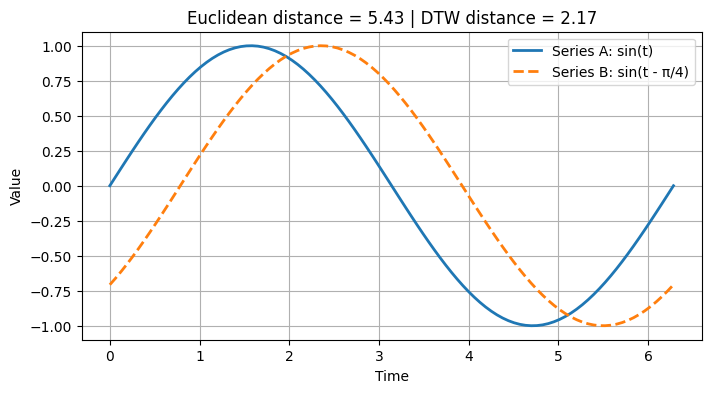

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dtaidistance import dtw, dtw_visualisation as dtwvis
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean

# Create two time series
t = np.linspace(0, 2 * np.pi, 100)
series_a = np.sin(t)
series_b = np.sin(t - np.pi / 4)  # shifted sine wave

# Compute distances
eucl_dist = euclidean(series_a, series_b)
dtw_dist = dtw.distance(series_a, series_b)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(t, series_a, label="Series A: sin(t)", linewidth=2)
plt.plot(t, series_b, label="Series B: sin(t - π/4)", linewidth=2, linestyle="--")
plt.title(f"Euclidean distance = {eucl_dist:.2f} | DTW distance = {dtw_dist:.2f}")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.show()


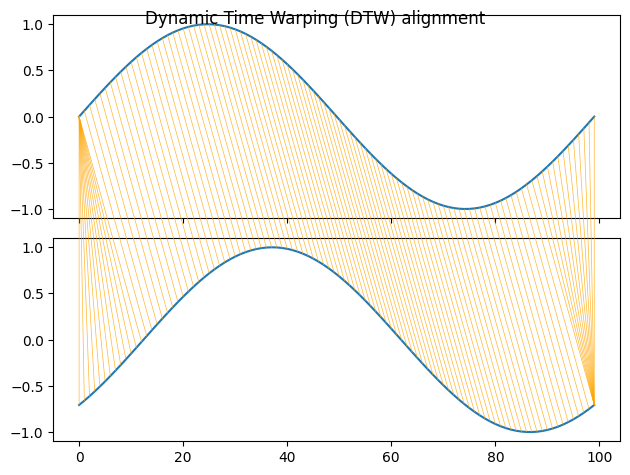

In [ ]:

#@title -- DTW alignment visualization ---
path = dtw.warping_path(series_a, series_b)
dtwvis.plot_warping(series_a, series_b, path, filename=None)
plt.suptitle("Dynamic Time Warping (DTW) alignment")
plt.show()



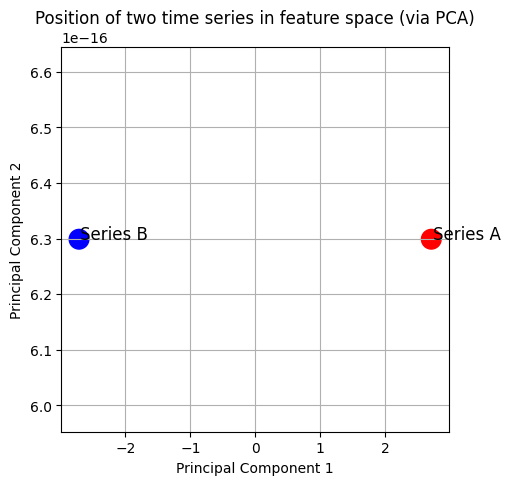

In [ ]:

#@title -- Vector-space interpretation --
# Suppose we treat each series as a 100-dimensional point
X = np.vstack([series_a, series_b])

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(5, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=200, c=['red', 'blue'])
for i, name in enumerate(['Series A', 'Series B']):
    plt.text(X_pca[i, 0]+0.02, X_pca[i, 1], name, fontsize=12)
plt.title("Position of two time series in feature space (via PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

# 1.Time Series Distance-Based Clustering

Instead of Euclidean distance (not great for time series), you can use time series–specific distance measures,

a. Dynamic Time Warping (DTW)

- Allows sequences to be out of phase (time-shifted).

- Often combined with k-medoids (PAM) or hierarchical clustering.

- Libraries:
  - `from tslearn.clustering import TimeSeriesKMeans with metric="dtw".`
  - `dtaidistance` (fast DTW implementation).

b. Shape-Based Distances

- Correlation-based distances (shape similarity regardless of amplitude).

- Soft-DTW (differentiable version of DTW).

✅ Good for small/mid-size datasets (hundreds–thousands of series).

❌ Distance matrix is O(N²), so scaling to millions is expensive.

In [ ]:
# --- Install dependencies ---
!pip install tslearn

In [ ]:

# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance


In [ ]:
# --- 1. Generate synthetic time series data ---
np.random.seed(42)
n_series = 90
n_timestamps = 60

# Create 3 groups with different shapes
group1 = np.sin(np.linspace(0, 3*np.pi, n_timestamps)) + 0.1*np.random.randn(n_series//3, n_timestamps)
group2 = np.sign(np.sin(np.linspace(0, 3*np.pi, n_timestamps))) + 0.1*np.random.randn(n_series//3, n_timestamps)
group3 = np.linspace(0, 1, n_timestamps) + 0.1*np.random.randn(n_series//3, n_timestamps)

# Combine all groups
X = np.vstack([group1, group2, group3])
X = X[:, :, np.newaxis]  # tslearn expects shape = (n_samples, n_timestamps, n_features)
X = TimeSeriesScalerMeanVariance().fit_transform(X)



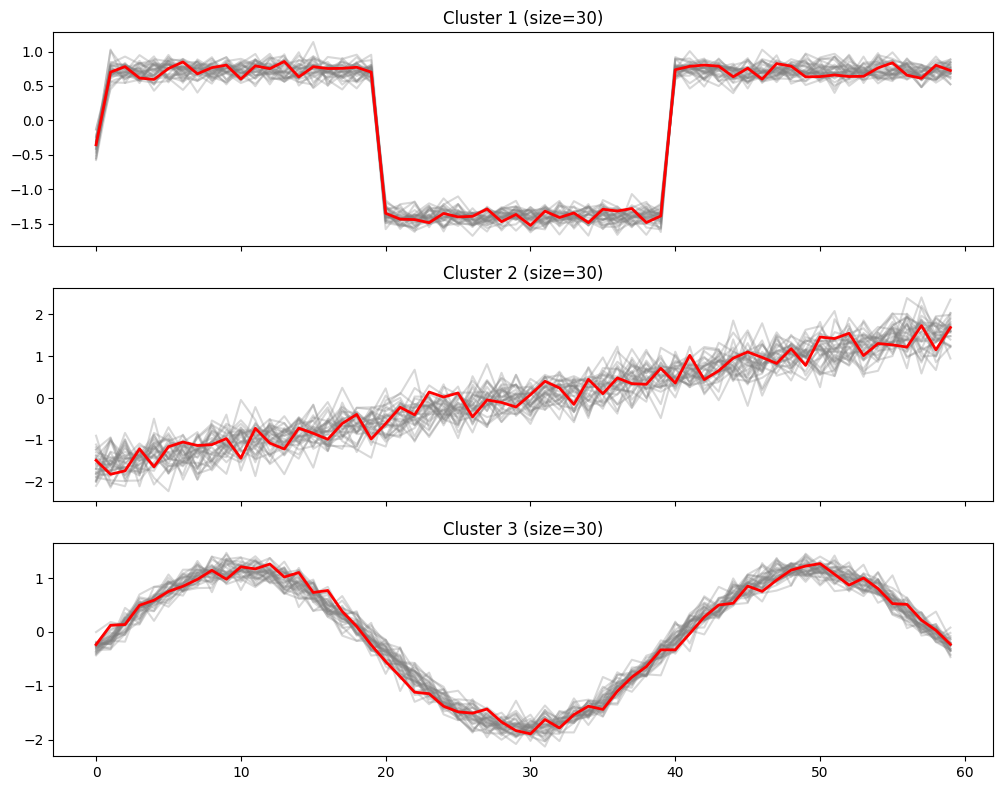

In [ ]:
# --- 2. Cluster using DTW-based KMeans ---
n_clusters = 3
dtw_km = TimeSeriesKMeans(
    n_clusters=n_clusters,
    metric="dtw",
    n_jobs=-1,
    random_state=42,
    verbose=False
)
y_pred = dtw_km.fit_predict(X)

# --- 3. Visualize clusters ---
fig, axes = plt.subplots(n_clusters, 1, figsize=(10, 8), sharex=True)

for cluster_idx in range(n_clusters):
    cluster_series = X[y_pred == cluster_idx]
    for ts in cluster_series:
        axes[cluster_idx].plot(ts.ravel(), color="gray", alpha=0.3)

    # plot centroid
    axes[cluster_idx].plot(
        dtw_km.cluster_centers_[cluster_idx].ravel(),
        color="red", linewidth=2
    )
    axes[cluster_idx].set_title(f"Cluster {cluster_idx+1} (size={len(cluster_series)})")

plt.tight_layout()
plt.show()


# 2.Feature Learning Clustering - Machine Learning

- Fit a time series model (e.g., ARIMA, VAR, HMM) to each series.

- Use the model parameters (e.g., AR coefficients, transition probs) as the representation.

- Cluster based on these parameter vectors. <br>
<br>


✅ Captures dynamics, not just raw similarity.

❌ Requires good model fits per series (expensive, brittle for noisy short series).

Example AR features:
   intercept       ar1       ar2       ar3
0  -0.009135  1.081510  0.210861 -0.337505
1  -0.005924  1.010797  0.422175 -0.484707
2  -0.007768  0.939535  0.350566 -0.335647
3  -0.005059  0.988280  0.277516 -0.317338
4  -0.010562  0.923503  0.358551 -0.330564


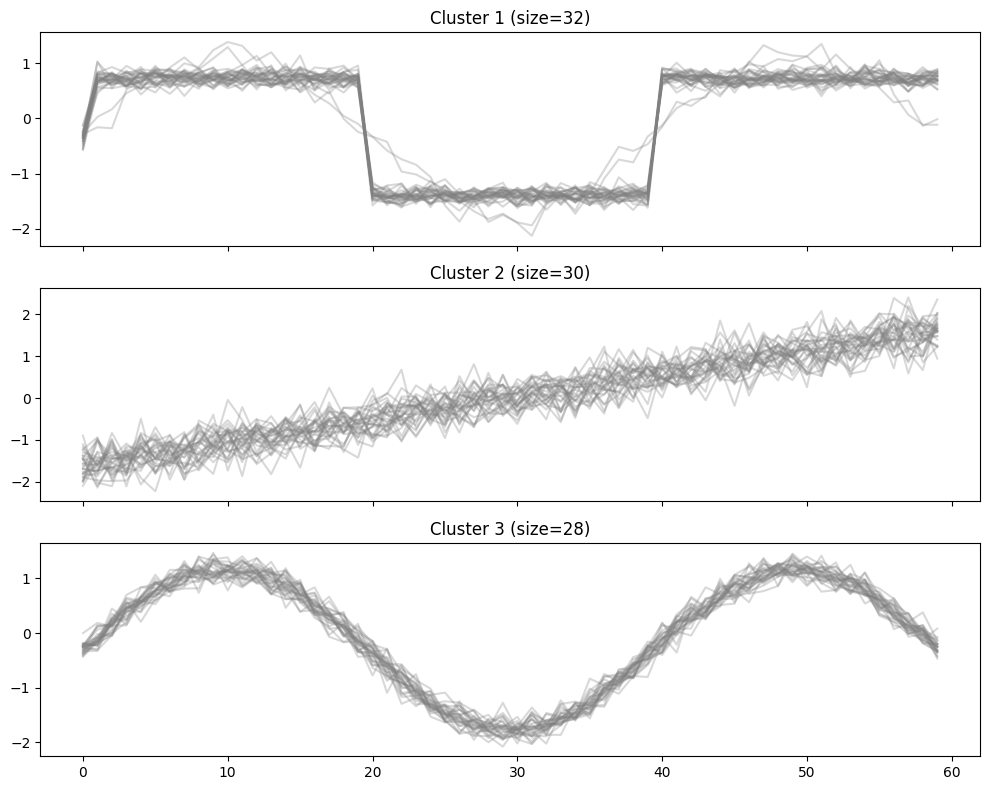

In [ ]:

from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AutoReg


# --- 2. Fit AR models and extract coefficients ---
def extract_ar_features(ts, lags=3):
    """Fit AR(lags) model and return its coefficients."""
    model = AutoReg(ts, lags=lags, old_names=False).fit()
    return model.params  # intercept + AR coefficients

features = np.array([extract_ar_features(ts, lags=3) for ts in X])
features_df = pd.DataFrame(features, columns=["intercept", "ar1", "ar2", "ar3"])

print("Example AR features:")
print(features_df.head())

# --- 3. Cluster based on AR coefficients ---
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
y_pred = kmeans.fit_predict(features)

# --- 4. Visualize clusters ---
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

for cluster_idx in range(3):
    cluster_series = X[y_pred == cluster_idx]
    for ts in cluster_series:
        axes[cluster_idx].plot(ts, color="gray", alpha=0.3)
    axes[cluster_idx].set_title(f"Cluster {cluster_idx+1} (size={len(cluster_series)})")

plt.tight_layout()
plt.show()

There are different types of models. When using this method, it is important to be clear about
- what the attributes (parameters) of the chosen model represent
- how they capture the characteristics of the time series.

For example, each time series is fitted with an AR(3) model:

$$
y_t = \phi_0 + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \phi_3 y_{t-3} + \varepsilon_t
$$

The coefficients [φ₀, φ₁, φ₂, φ₃] capture the series’ dynamics (trend, persistence, etc.).

# 3.Feature Learning Clustering - Deep Learning embedding

Instead of hand-crafted statistics, learn embeddings:

Autoencoders

- Train a 1D CNN/LSTM autoencoder.

- Use the latent representation (the bottleneck layer) as features.

- Cluster embeddings with k-means or DBSCAN.

Sequence-to-sequence embeddings

- Use RNN/Transformer encoders (e.g., PyTorch, TensorFlow).

- Extract fixed-length vectors for variable-length series.

**Pretrained models (like ts2vec, TNC).**

✅ Scales better, captures nonlinear/long-term patterns.
❌ Requires training infrastructure, larger datasets.

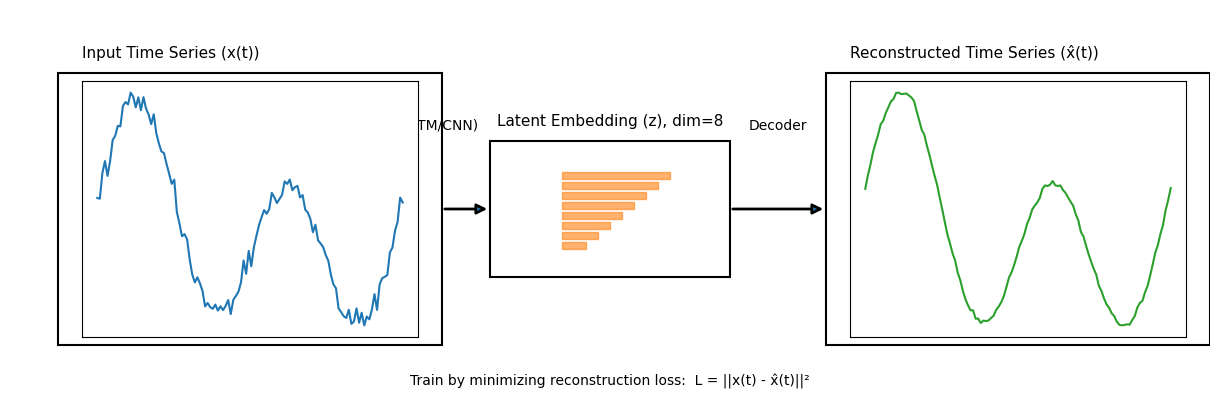

In [ ]:
#@title time series 𝑥(𝑡)->latent vector 𝑧 ->decoder reconstructs 𝑥(^𝑡)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Rectangle

def draw_ts_autoencoder_diagram(T=120, latent_dim=8, noise=0.1, seed=42):
    rng = np.random.default_rng(seed)
    t = np.linspace(0, 4*np.pi, T)

    # Simulated input and reconstructed series
    x = np.sin(t) + 0.5*np.sin(0.5*t + 0.7) + noise * rng.standard_normal(T)
    x_rec = np.sin(t + 0.1) + 0.5*np.sin(0.5*t + 0.8)
    x_rec = 0.85 * x_rec + 0.15 * rng.standard_normal(T) * noise

    # Create figure
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis("off")

    # Layout positions
    left_panel = [0.06, 0.18, 0.28, 0.64]
    mid_panel  = [0.42, 0.35, 0.16, 0.30]
    right_panel= [0.70, 0.18, 0.28, 0.64]

    # --- Left: Input Time Series ---
    ax.add_patch(Rectangle((left_panel[0]-0.02, left_panel[1]-0.02),
                           left_panel[2]+0.04, left_panel[3]+0.04,
                           fill=False, lw=1.5))
    ax.text(left_panel[0], left_panel[1]+left_panel[3]+0.06,
            "Input Time Series (x(t))", fontsize=11, ha="left")

    inset1 = fig.add_axes(left_panel)
    inset1.plot(x, color='C0')
    inset1.set_xticks([]); inset1.set_yticks([])

    # --- Middle: Latent Vector ---
    ax.add_patch(Rectangle((mid_panel[0]-0.02, mid_panel[1]-0.02),
                           mid_panel[2]+0.04, mid_panel[3]+0.04,
                           fill=False, lw=1.5))
    ax.text(mid_panel[0]+mid_panel[2]/2, mid_panel[1]+mid_panel[3]+0.06,
            f"Latent Embedding (z), dim={latent_dim}", fontsize=11, ha="center")

    # Draw latent bars
    z_vals = np.linspace(0.2, 0.9, latent_dim)
    bar_x0, bar_y0 = mid_panel[0]+0.04, mid_panel[1]+0.05
    bar_h = (mid_panel[3]-0.10) / latent_dim
    for i, z in enumerate(z_vals):
        rect = Rectangle((bar_x0, bar_y0 + i*bar_h), 0.10*z, bar_h*0.7,
                         fill=True, alpha=0.6, color='C1')
        ax.add_patch(rect)

    # --- Right: Reconstructed Time Series ---
    ax.add_patch(Rectangle((right_panel[0]-0.02, right_panel[1]-0.02),
                           right_panel[2]+0.04, right_panel[3]+0.04,
                           fill=False, lw=1.5))
    ax.text(right_panel[0], right_panel[1]+right_panel[3]+0.06,
            "Reconstructed Time Series (x̂(t))", fontsize=11, ha="left")

    inset3 = fig.add_axes(right_panel)
    inset3.plot(x_rec, color='C2')
    inset3.set_xticks([]); inset3.set_yticks([])

    # --- Arrows and Labels ---
    ax.add_patch(FancyArrowPatch(
        (left_panel[0]+left_panel[2]+0.02, left_panel[1]+left_panel[3]/2),
        (mid_panel[0]-0.02, mid_panel[1]+mid_panel[3]/2),
        arrowstyle="-|>", mutation_scale=15, lw=2))
    ax.text(0.33, 0.7, "Encoder (LSTM/CNN)", fontsize=10, ha="center")

    ax.add_patch(FancyArrowPatch(
        (mid_panel[0]+mid_panel[2]+0.02, mid_panel[1]+mid_panel[3]/2),
        (right_panel[0]-0.02, right_panel[1]+right_panel[3]/2),
        arrowstyle="-|>", mutation_scale=15, lw=2))
    ax.text(0.64, 0.7, "Decoder", fontsize=10, ha="center")

    # Loss annotation
    ax.text(0.5, 0.06,
            "Train by minimizing reconstruction loss:  L = ||x(t) - x̂(t)||²",
            fontsize=10, ha="center")


    plt.show()

draw_ts_autoencoder_diagram()



In [ ]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense


- Train	The network learns to reconstruct input time series, forcing the bottleneck to capture essential temporal dynamics.
- Extract embeddings	After training, each series is represented as a fixed-length vector (its latent embedding).

In [ ]:

# --- 2. Define LSTM Autoencoder ---
timesteps = X.shape[1]
n_features = X.shape[2]
latent_dim = 8  # bottleneck dimension

inputs = Input(shape=(timesteps, n_features))
encoded = LSTM(64, activation='tanh', return_sequences=True)(inputs)
encoded = LSTM(latent_dim, activation='tanh', return_sequences=False)(encoded)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(64, activation='tanh', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(n_features))(decoded)

autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)  # for extracting embeddings

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# --- 3. Train the Autoencoder ---
history = autoencoder.fit(
    X, X,
    epochs=20,
    batch_size=8,
    validation_split=0.2,
    verbose=1
)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 8)              │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 60, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 60, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 60, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,985 (148.38 KB)

 Trainable params: 37,985 (148.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 229ms/step - loss: 0.9997 - val_loss: 0.9908
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.9940 - val_loss: 0.9548
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.9711 - val_loss: 0.7785
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.9038 - val_loss: 0.5401
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.7371 - val_loss: 0.3418
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.2479 - val_loss: 0.2953
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.1778 - val_loss: 0.2563
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.1625 - val_loss: 0.2388
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.1538 - val_loss: 0.2348
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.1428 - val_loss: 0.2246
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.1392 - val_loss: 0.2165
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.1348 - val_loss: 0.2086

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Embeddings shape: (90, 8)
Silhouette Score: 0.928


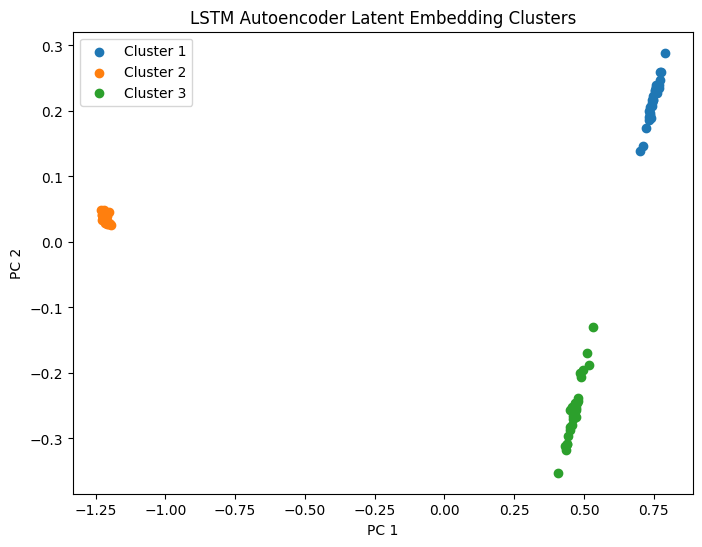

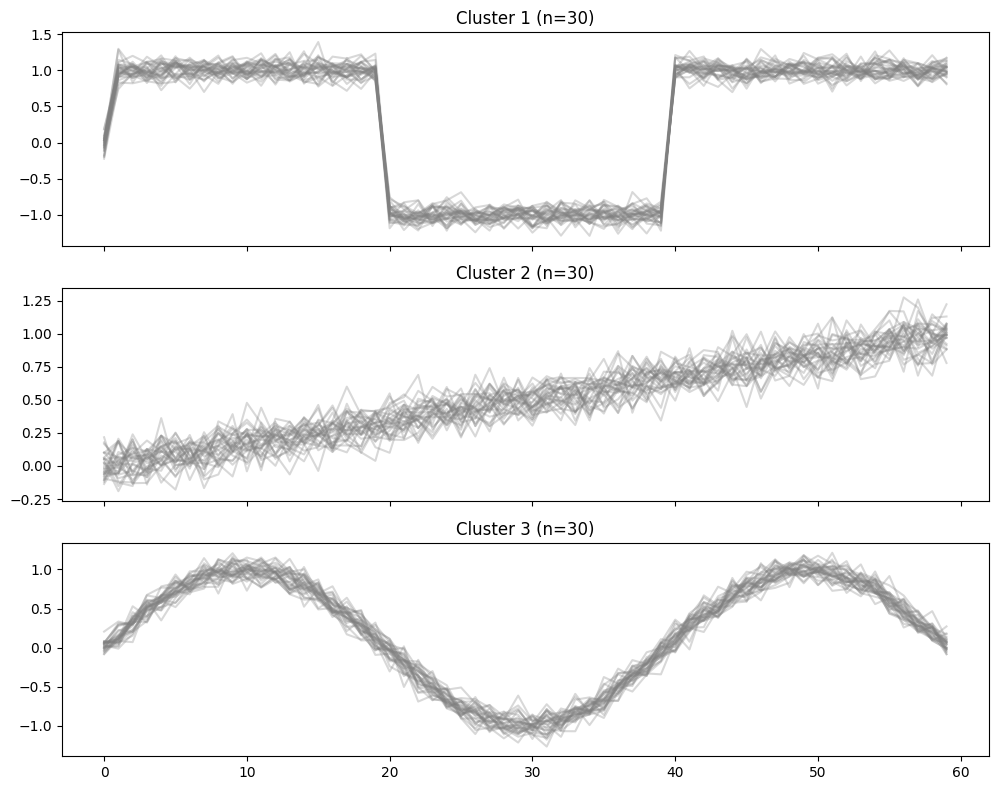

In [ ]:


# --- 4. Extract Latent Representations ---
embeddings = encoder.predict(X)
print("Embeddings shape:", embeddings.shape)

# --- 5. Cluster embeddings ---
kmeans = KMeans(n_clusters=3, random_state=42)
y_pred = kmeans.fit_predict(embeddings)
sil = silhouette_score(embeddings, y_pred)
print(f"Silhouette Score: {sil:.3f}")

# --- 6. Visualize embeddings in 2D ---
from sklearn.decomposition import PCA
emb_2d = PCA(n_components=2).fit_transform(embeddings)

plt.figure(figsize=(8, 6))
for cluster in range(3):
    plt.scatter(emb_2d[y_pred == cluster, 0], emb_2d[y_pred == cluster, 1], label=f"Cluster {cluster+1}")
plt.title("LSTM Autoencoder Latent Embedding Clusters")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.show()

# --- 7. Visualize clustered series ---
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
for cluster in range(3):
    for ts in X[y_pred == cluster]:
        axes[cluster].plot(ts.squeeze(), color="gray", alpha=0.3)
    axes[cluster].set_title(f"Cluster {cluster+1} (n={sum(y_pred==cluster)})")
plt.tight_layout()
plt.show()


# 4.Pretrained Deep Learning Embedding
## TS2Vec: Towards Universal Representation of Time Series

https://github.com/zhihanyue/ts2vec <br>
https://arxiv.org/abs/2106.10466


The goal of TS2Vec encoder is to produce fixed-length embeddings representation of the entire temporal sequence
- similar to how an autoencoder or BERT summarizes an entire sentence into an embedding vector.

You can later apply Clustering on the latent vectors.
- **Distance in this latent space ≈ “semantic similarity of time series behavior.”**


A time series can be viewed as a sentence — both are ordered sequences where context matters.
- In natural language processing (NLP), models such as BERT or Word2Vec learn embeddings that capture the semantic meaning of words within their context.
- Similarly, in time series analysis, models like TS2Vec learn embeddings that capture temporal dynamics — such as trends, periodicity, and shape patterns — across time steps.

Therefore, TS2Vec functions much like a pretrained embedding model in NLP, providing fixed-length vector representations that encode the “meaning” or behavior of entire time series.

In [ ]:
!pip install ts2vec

In [ ]:
X.shape

(90, 60, 1)

Epoch #0: loss=3.0909388065338135
Epoch #1: loss=2.6705015182495115
Epoch #2: loss=2.5744297981262205
Epoch #3: loss=2.5835551261901855
Epoch #4: loss=2.3331454038619994
Epoch #5: loss=2.5393229007720945
Epoch #6: loss=2.3590841770172117
Epoch #7: loss=2.4210819721221926
Epoch #8: loss=2.222926902770996
Epoch #9: loss=2.3493111610412596
Embeddings shape: (90, 60, 64)
Reshaped embeddings shape: (90, 3840)


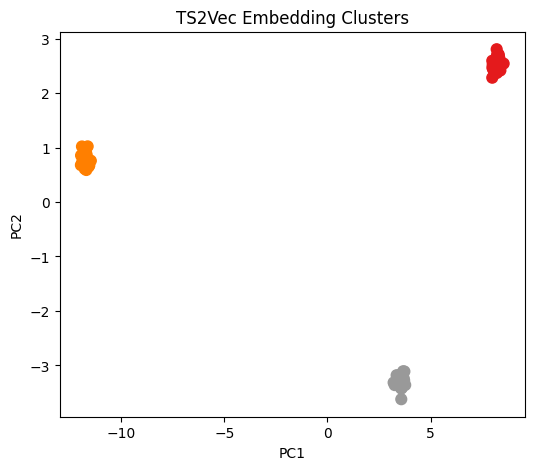

In [ ]:
import numpy as np
import torch
from ts2vec import TS2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 2️⃣ Train TS2Vec model
model = TS2Vec(input_dims=1,output_dims=64, device='cuda' if torch.cuda.is_available() else 'cpu')
model.fit(X, verbose=True, n_epochs=10)

# 3️⃣ Encode to latent representations
embeddings = model.encode(X)  # shape: (n_samples, n_timestamps, embedding_dim)
print("Embeddings shape:", embeddings.shape)

# Reshape embeddings for KMeans (flatten the last two dimensions)
n_samples, n_timestamps, embedding_dim = embeddings.shape
embeddings_reshaped = embeddings.reshape(n_samples, n_timestamps * embedding_dim)
print("Reshaped embeddings shape:", embeddings_reshaped.shape)


# 4️⃣ Cluster embeddings
kmeans = KMeans(n_clusters=3, random_state=0).fit(embeddings_reshaped)
labels = kmeans.labels_

# 5️⃣ Visualize embeddings (PCA to 2D)
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings_reshaped)

plt.figure(figsize=(6,5))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap="Set1", s=60)
plt.title("TS2Vec Embedding Clusters")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

In the official TS2Vec implementation, the default choice of embedding dimension is `output_dims=320`.
It was empirically chosen by the authors because:

- They trained on long multivariate time series (e.g., 1000+ timesteps, 10+ features).
- They wanted rich embeddings that generalize across datasets.


**Recommended practice**

        | Sequence length | Recommended embedding dim |
        | --------------- | ------------------------- |
        | 50–100          | 32–64                     |
        | 200–500         | 64–128                    |
        | 500–1000+       | 128–256 (or 320 max)      |

# 5.Shapelet / Subsequence-Based Clustering

- Look for characteristic subsequences ("shapelets") that best separate groups of series.

- Cluster series based on presence/absence of these shapelets.

- Implemented in tslearn.shapelets.



✅ Intuitive: "these customers have similar peaks/dips patterns".<br>
❌ Computationally heavy, needs subsequence discovery.

In [ ]:
from tslearn.shapelets import ShapeletModel
from tslearn.utils import to_time_series_dataset
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# --- 2. Learn shapelets (unsupervised feature extraction) ---
# ShapeletModel is supervised by default, so we create pseudo-labels via unsupervised partitioning
n_clusters = 3
initial_labels = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(X.reshape(X.shape[0], -1))

# Define the shapelet model
shapelet_sizes = {10: 5, 20: 5}  # {shapelet_length: n_shapelets}
shapelet_model = ShapeletModel(n_shapelets_per_size=shapelet_sizes, optimizer="sgd", random_state=42, verbose=0)

# Train the shapelet model to learn patterns from data
shapelet_model.fit(X, initial_labels)

# Transform series into shapelet distance features
X_shapelet = shapelet_model.transform(X)
print("Shapelet feature shape:", X_shapelet.shape)

# --- 3. Cluster using shapelet distance features ---
cluster_model = KMeans(n_clusters=n_clusters, random_state=42)
y_pred = cluster_model.fit_predict(X_shapelet)

# Evaluate
silhouette = silhouette_score(X_shapelet, y_pred)
print(f"Silhouette Score: {silhouette:.3f}")

# --- 4. Visualize results ---
fig, axes = plt.subplots(n_clusters, 1, figsize=(10, 8), sharex=True)

for cluster_idx in range(n_clusters):
    cluster_series = X[y_pred == cluster_idx]
    for ts in cluster_series:
        axes[cluster_idx].plot(ts.ravel(), color="gray", alpha=0.3)
    axes[cluster_idx].set_title(f"Cluster {cluster_idx+1} (size={len(cluster_series)})")

plt.tight_layout()
plt.show()
